In [88]:
import os
import glob
import pathlib

import xml.etree.ElementTree as et
from xml.dom import minidom

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras

from PIL import Image

import shap
import random

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications import MobileNetV3Large

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix
import xgboost as xgb

import random
import matplotlib.cm as cm
from matplotlib.image import imread

np.random.seed(42)

from matplotlib import style
style.use('seaborn-pastel')

Set path to access dataset

In [89]:
data_dir = './sgtraffic'
train_path = './sgtraffic/Train'
test_path = './sgtraffic/Test'

Controlling the image at fixed image size to improve computing

In [90]:
img_ht = 50
img_wd = 50
channels = 3

Understanding classes

In [91]:
classes = {
0:"INFO_END_OF_EXP_WAY",
1:"PROHIBITORY_NO_JAYWALKING",
2:"INFO_TP_CAMERA_ZONE",
3:"PROHIBITORY_SPD_LIMIT_90",
4:"MANDATORY_TURN_LEFT",
5:"WARNING_ERP",
6:"PROHIBITORY_SPD_LIMIT_70",
7:"INFO_U_TURN_LANE",
8:"MANDATORY_SPLIT_WAY",
9:"MANDATORY_STOP",
10:"PROHIBITORY_SPD_LIMIT_50",
11:"WARNING_CURVE_RIGHT_ALIGNMENT_MARKER",
12:"INFO_ZEBRA_CROSSING",
13:"INFO_RAIN_SHELTER",
14:"PROHIBITORY_NO_ENTRY",
15:"MANDATORY_KEEP_LEFT",
16:"INFO_PARKING_AREA_FOR_MOTORCARS",
17:"INFO_PEDESTRIAN_USE_CROSSING",
18:"WARNING_RESTRICTED_ZONE_AHEAD",
19:"WARNING_CURVE_LEFT_ALIGNMENT_MARKER",
20:"INFO_START_OF_EXP_WAY",
21:"MANDATORY_GIVE_WAY",
22:"PROHIBITORY_NO_VEH_OVER_HEIGHT_4.5",
23:"PROHIBITORY_SPD_LIMIT_40",
24:"WARNING_SLOW_SPEED",
25:"WARNING_ROAD_HUMP",
26:"PROHIBITORY_NO_LEFT_TURN",
27:"INFO_ONE_WAY_RIGHT",
28:"INFO_ONE_WAY_LEFT",
29:"WARNING_SLOW_DOWN",
30:"WARNING_MERGE",
31:"PROHIBITORY_NO_RIGHT_TURN"
}

In [92]:
input_shape = (img_ht, img_wd, channels)
input_layer = tf.keras.layers.Input(input_shape)

In [93]:
bl = keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', name='bl1')(input_layer)
bl = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='bl2')(bl)
bl = keras.layers.MaxPool2D(pool_size=(2, 2), name='bl3')(bl)
bl = keras.layers.BatchNormalization(axis=-1, name='bl4')(bl)

bl = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='bl5')(bl)
bl = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='bl6')(bl)
bl = keras.layers.MaxPool2D(pool_size=(2, 2), name='bl7')(bl)
bl = keras.layers.BatchNormalization(axis=-1, name='bl8')(bl)

bl = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', name='bl9')(bl)
bl = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', name='bl10')(bl)
bl = keras.layers.MaxPool2D(pool_size=(2, 2), name='bl11')(bl)
bl = keras.layers.BatchNormalization(axis=-1, name='bl12')(bl)

bl = keras.layers.Flatten(name='bl13')(bl)

classifier_branch = keras.layers.Dense(1024, activation='relu', name='cl1')(bl)
classifier_branch = keras.layers.BatchNormalization(name='cl2')(bl)
classifier_branch = keras.layers.Dropout(rate=0.5, name='cl3')(bl)

classifier_branch = keras.layers.Dense(32, activation='softmax', name='cl_head')(classifier_branch)

locator_branch = keras.layers.Dense(1024, activation='relu', name='bb1')(bl)
locator_branch = keras.layers.Dense(532, activation='relu', name='bb2')(locator_branch)
locator_branch = keras.layers.Dense(256, activation='relu', name='bb3')(locator_branch)
locator_branch = keras.layers.Dense(128, activation='relu', name='bb4')(locator_branch)
locator_branch = keras.layers.Dense(64, activation='relu', name='bb5')(locator_branch)
locator_branch = keras.layers.Dense(32, activation='relu', name='bb6')(locator_branch)
locator_branch = keras.layers.Dropout(rate=0.1, name='bb7')(locator_branch)

locator_branch = keras.layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

locator_model = tf.keras.Model(input_layer, outputs = [classifier_branch, locator_branch])

locator_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 bl1 (Conv2D)                   (None, 48, 48, 16)   448         ['input_15[0][0]']               
                                                                                                  
 bl2 (Conv2D)                   (None, 46, 46, 32)   4640        ['bl1[0][0]']                    
                                                                                                  
 bl3 (MaxPooling2D)             (None, 23, 23, 32)   0           ['bl2[0][0]']                    
                                                                                            

In [94]:
img_xml_dir_train = './sgtraffic_labelimg/bb_train/'
img_xml_dir_test = './sgtraffic_labelimg/bb_test/'

In [95]:
def xml_append_df(path):
  xml_list = []
  try:
    for xml_file in glob.glob(path + '*.xml'):
      xtree = et.parse(xml_file)
      xroot = xtree.getroot()
      for node in xroot.findall('object'):
        values = [xroot.find('path').text, # path
                  xroot.find('filename').text, # filename
                  xroot.find("size")[0].text, # width
                  xroot.find("size")[1].text, # height
                  node[0].text, # name/class
                  node[4][0].text, # xmin
                  node[4][1].text, # ymin
                  node[4][2].text, # xmax
                  node[4][3].text # ymax
                  ]
        xml_list.append(values)
  except:
        print(f'unable to append {xml_file}')

  col_name = ['path', 'filename', 'width', 'height', 'class_name', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=col_name)
  return xml_df

In [96]:
train_xml_df = xml_append_df(img_xml_dir_train)

In [97]:
test_xml_df = xml_append_df(img_xml_dir_test)

In [98]:
train_xml_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0059.jpg,63,63,8,8,9,58,58
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0063.jpg,111,114,8,12,13,100,100
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0065.jpg,159,189,8,20,20,139,164
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0163.jpg,99,99,8,18,11,81,90
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0167.jpg,60,60,10,16,16,47,44
...,...,...,...,...,...,...,...,...,...
1475,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,6544.JPG,111,166,7,24,25,85,144
1476,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,6675.JPG,228,169,0,16,19,149,161
1477,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,7654.JPG,151,159,10,39,41,111,114
1478,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,7877.JPG,134,143,7,31,21,113,128


In [99]:
test_xml_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0283.jpg,48,48,1,4,2,46,44
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0356.jpg,42,42,0,4,3,40,39
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0397.jpg,51,51,1,4,4,44,46
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0553.jpg,80,80,7,12,7,65,73
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0601.jpg,76,76,3,3,4,74,74
...,...,...,...,...,...,...,...,...,...
98,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5623.jpg,177,177,14,14,67,165,114
99,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5644.jpg,148,148,14,11,50,126,98
100,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5920.jpg,152,152,3,20,24,141,144
101,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5968.jpg,252,252,3,30,37,239,231


In [100]:
class_dist = train_xml_df.groupby('class_name').count().reset_index()[['class_name', 'filename']]

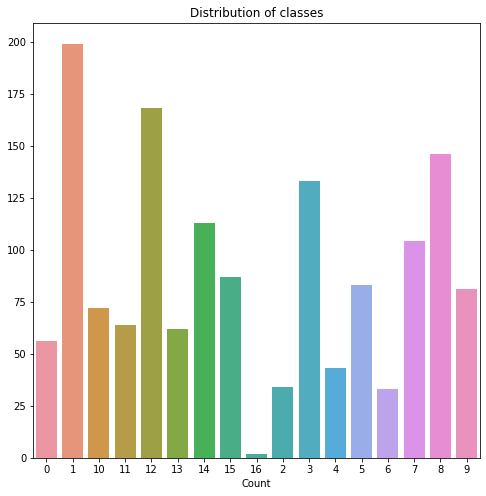

In [101]:
plt.figure(figsize=(8, 8))
sns.barplot(x=class_dist['class_name'], y=class_dist['filename'])
plt.title('Distribution of classes')
plt.ylabel('')
plt.xlabel('Count')
plt.show()

In [102]:
train_xml_df['path'][0]

'C:\\GA\\capstone\\objdetect\\sgtraffic_labelimg\\Train\\8\\0059.jpg'

In [103]:
groundtruth_df = train_xml_df[train_xml_df['filename'] == '0272.jpg']

In [104]:
groundtruth_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
22,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0272.jpg,71,71,1,4,3,67,66


In [105]:
draw = cv2.imread(groundtruth_df['path'].iloc[0])

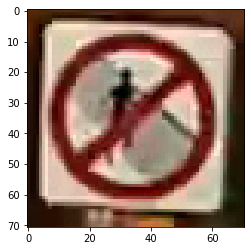

In [106]:
plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB));

In [107]:
groundtruth_df['xmin'].iloc[0]

'4'

In [108]:
start_pt = (int(groundtruth_df['xmin'].iloc[0]), int(groundtruth_df['ymin'].iloc[0]))
end_pt = (int(groundtruth_df['xmax'].iloc[0]), int(groundtruth_df['ymax'].iloc[0]))

In [109]:
color = (255, 0, 0)
thickness = 2

In [110]:
img_groundtruth = cv2.rectangle(draw, start_pt, end_pt, color, thickness)

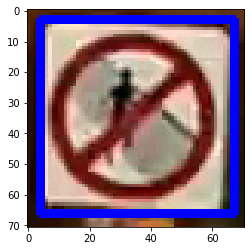

In [111]:
plt.imshow(cv2.cvtColor(img_groundtruth, cv2.COLOR_BGR2RGB));

Define training images

In [112]:
training_img = train_xml_df[['path']]

In [113]:
training_img

,path
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
...,...
1475,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1476,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1477,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1478,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...


In [114]:
train_images = []
train_targets = []
train_labels = []

In [115]:
for index, row in train_xml_df.iterrows():
    (path, filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    train_img_fullpath = path

    xmin = round(int(xmin)/int(width), 2)
    ymin = round(int(ymin)/int(height), 2)
    xmax = round(int(xmax)/int(width), 2)
    ymax = round(int(ymax)/int(height), 2)

    height = img_ht
    width = img_wd

    train_img = keras.preprocessing.image.load_img(train_img_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    train_img_arr = train_img_arr / 255

    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(int(class_name))

In [116]:
print(f'train_images = {len(train_images)}, train_targets = {len(train_targets)}, train_labels = {len(train_labels)}')

train_images = 1480, train_targets = 1480, train_labels = 1480


In [117]:
train_images_arr = np.array(train_images, dtype=float)
train_targets_arr = np.array(train_targets, dtype=float)
train_labels_arr = np.array(train_labels, dtype=float)

## Test Dataset

In [118]:
test_images = []
test_targets = []
test_labels = []
test_area = []

In [119]:
classes_list = list(test_xml_df['class_name'].unique())
classes_list

['1', '0', '7', '3', '14', '15', '9', '2', '13', '10', '8', '12', '11']

In [120]:
test_xml_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0283.jpg,48,48,1,4,2,46,44
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0356.jpg,42,42,0,4,3,40,39
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0397.jpg,51,51,1,4,4,44,46
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0553.jpg,80,80,7,12,7,65,73
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0601.jpg,76,76,3,3,4,74,74
...,...,...,...,...,...,...,...,...,...
98,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5623.jpg,177,177,14,14,67,165,114
99,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5644.jpg,148,148,14,11,50,126,98
100,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5920.jpg,152,152,3,20,24,141,144
101,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5968.jpg,252,252,3,30,37,239,231


In [121]:
test_xml_df['xmin'] = test_xml_df['xmin'].astype(int)
test_xml_df['ymin'] = test_xml_df['ymin'].astype(int)
test_xml_df['xmax'] = test_xml_df['xmax'].astype(int)
test_xml_df['ymax'] = test_xml_df['ymax'].astype(int)

In [122]:
test_xml_df['area'] = (test_xml_df['xmax'] - test_xml_df['xmin']) * (test_xml_df['ymax'] - test_xml_df['ymin'])

In [123]:
for index, row in test_xml_df.iterrows():
    (path, filename, width, height, class_name, xmin, ymin, xmax, ymax, area) = row
    test_img_fullpath = path

    xmin = round(int(xmin)/int(width), 2)
    ymin = round(int(ymin)/int(height), 2)
    xmax = round(int(xmax)/int(width), 2)
    ymax = round(int(ymax)/int(height), 2)

    height = img_ht
    width = img_wd

    test_img = keras.preprocessing.image.load_img(test_img_fullpath, target_size=(height, width))
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    test_img_arr = test_img_arr / 255

    test_area.append(area)
    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(int(class_name))

In [124]:
print(f'test_images = {len(test_images)}, test_targets = {len(test_targets)}, test_labels = {len(test_labels)}')

test_images = 103, test_targets = 103, test_labels = 103


In [125]:
test_images_arr = np.array(test_images, dtype=float)
test_targets_arr = np.array(test_targets, dtype=float)
test_labels_arr = np.array(test_labels, dtype=float)

Modeling

In [126]:
locator_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 bl1 (Conv2D)                   (None, 48, 48, 16)   448         ['input_15[0][0]']               
                                                                                                  
 bl2 (Conv2D)                   (None, 46, 46, 32)   4640        ['bl1[0][0]']                    
                                                                                                  
 bl3 (MaxPooling2D)             (None, 23, 23, 32)   0           ['bl2[0][0]']                    
                                                                                            

In [127]:
opt = Adam(learning_rate=0.001, amsgrad=True)

In [128]:
losses = {
    "cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    "bb_head":tf.keras.losses.MSE
   }

In [129]:
locator_model.compile(loss=losses, optimizer=opt, metrics=['accuracy'])

In [130]:
trainTargets = {
    "cl_head": train_labels_arr,
    "bb_head": train_targets_arr
}
validationTargets = {
    "cl_head": test_labels_arr,
    "bb_head": test_targets_arr
}

In [131]:
es = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, mode='auto', verbose=1)

In [132]:
dual_history = locator_model.fit(train_images_arr, trainTargets,
                                 validation_data = (test_images_arr,
                                                    validationTargets),
                                 batch_size = 32,
                                 epochs = 200,
                                 callbacks=[es])

Epoch 1/200


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"


47/47 [==============================] - 9s 184ms/step - loss: 0.6992 - cl_head_loss: 0.6734 - bb_head_loss: 0.0258 - cl_head_accuracy: 0.8446 - bb_head_accuracy: 0.5351 - val_loss: 3.0660 - val_cl_head_loss: 3.0554 - val_bb_head_loss: 0.0106 - val_cl_head_accuracy: 0.0194 - val_bb_head_accuracy: 0.7767
Epoch 2/200
47/47 [==============================] - 9s 181ms/step - loss: 0.1711 - cl_head_loss: 0.1643 - bb_head_loss: 0.0068 - cl_head_accuracy: 0.9669 - bb_head_accuracy: 0.6500 - val_loss: 2.8417 - val_cl_head_loss: 2.8194 - val_bb_head_loss: 0.0223 - val_cl_head_accuracy: 0.0194 - val_bb_head_accuracy: 0.2233
Epoch 3/200
47/47 [==============================] - 8s 180ms/step - loss: 0.1045 - cl_head_loss: 0.0998 - bb_head_loss: 0.0048 - cl_head_accuracy: 0.9777 - bb_head_accuracy: 0.7236 - val_loss: 2.8455 - val_cl_head_loss: 2.8362 - val_bb_head_loss: 0.0093 - val_cl_head_accuracy: 0.0388 - val_bb_head_accuracy: 0.6699
Epoch 4/200
47/47 [==============================] - 8s 180ms

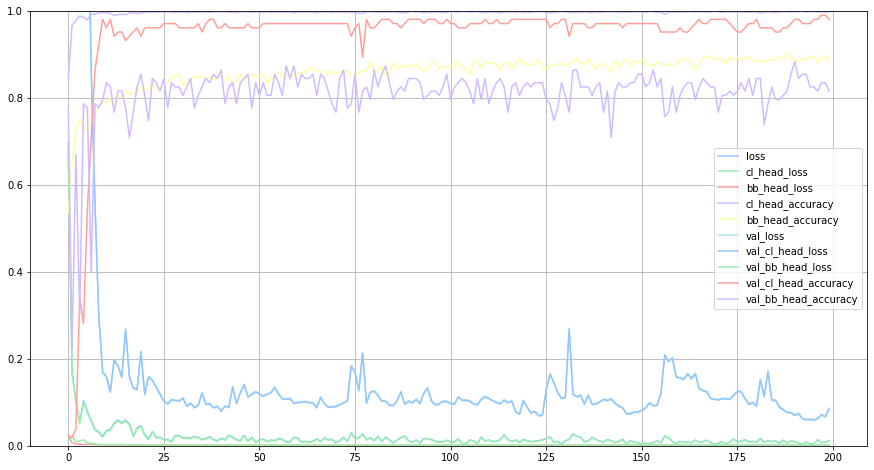

In [133]:
pd.DataFrame(dual_history.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [134]:
loc_pred = locator_model.predict(test_images_arr)

In [135]:
classes_xtest = np.argmax(loc_pred[0], axis=1)

In [136]:
test_labels_arr

array([ 1.,  0.,  1.,  7.,  3.,  1., 14., 14., 14., 14., 14., 15., 15.,
        1.,  9.,  9.,  0.,  2.,  3., 13., 13.,  3., 13.,  3., 10., 10.,
       10., 10., 10.,  8.,  0., 13., 15.,  1.,  1.,  3.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  8., 10.,  1., 15.,  1.,  1.,  1.,
        1.,  9.,  9.,  9.,  9., 15.,  1.,  1.,  1., 10.,  8.,  1.,  2.,
        8.,  0.,  0.,  0.,  8., 12., 12., 12., 12., 12.,  1., 11., 11.,
        1.,  7.,  1.,  1.,  1., 13., 14.,  3., 13., 13.,  0.,  0.,  3.,
       13., 13., 13., 13., 13., 13., 14., 14., 14.,  3.,  3.,  0.])

In [137]:
classes_xtest

array([ 1,  0,  1,  7,  3,  1, 14, 14, 14, 14, 14, 15, 15,  1,  9,  9,  0,
        2,  3, 13, 13,  3, 13,  3, 10, 10, 10, 10, 10,  8,  0, 13, 15,  1,
        1,  3,  0,  0,  0,  1,  1,  1,  1,  1,  1,  8, 10,  1,  8,  1,  1,
        1,  1,  9,  9,  9,  9, 15,  1,  1,  1, 10,  8,  1,  2,  8,  0,  0,
        0, 13, 12, 12, 12, 12, 12,  1, 11, 11,  1,  7,  1,  1,  1, 13, 14,
        3, 13, 13,  0,  0,  3, 13, 13, 13, 13, 13, 13, 14, 14, 14,  3,  3,
        0], dtype=int64)

In [138]:
print(classification_report(test_labels_arr, classes_xtest))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00        26
         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         9
         7.0       1.00      1.00      1.00         2
         8.0       0.80      0.80      0.80         5
         9.0       1.00      1.00      1.00         6
        10.0       1.00      1.00      1.00         7
        11.0       1.00      1.00      1.00         2
        12.0       1.00      1.00      1.00         5
        13.0       0.93      1.00      0.96        13
        14.0       1.00      1.00      1.00         9
        15.0       1.00      0.80      0.89         5

    accuracy                           0.98       103
   macro avg       0.98      0.97      0.97       103
weighted avg       0.98      0.98      0.98       103



Freeze base layers and continue training bounding box branch

In [155]:
for layer in locator_model.layers:
    if layer.name.startswith('bl_'):
        layer.trainable = False
        
for layer in locator_model.layers:
    if layer.name.startswith('cl_'):
        layer.trainable = False

In [157]:
locator_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 bl1 (Conv2D)                   (None, 48, 48, 16)   448         ['input_15[0][0]']               
                                                                                                  
 bl2 (Conv2D)                   (None, 46, 46, 32)   4640        ['bl1[0][0]']                    
                                                                                                  
 bl3 (MaxPooling2D)             (None, 23, 23, 32)   0           ['bl2[0][0]']                    
                                                                                            

In [158]:
dual_history = locator_model.fit(train_images_arr, trainTargets,
                                 validation_data = (test_images_arr,
                                                    validationTargets),
                                 batch_size = 32,
                                 epochs = 200,
                                 callbacks=[es])

Epoch 1/200
47/47 [==============================] - 8s 161ms/step - loss: 0.0110 - cl_head_loss: 0.0105 - bb_head_loss: 5.1487e-04 - cl_head_accuracy: 0.9973 - bb_head_accuracy: 0.8939 - val_loss: 753.7203 - val_cl_head_loss: 753.6956 - val_bb_head_loss: 0.0248 - val_cl_head_accuracy: 0.0194 - val_bb_head_accuracy: 0.6990
Epoch 2/200
47/47 [==============================] - 8s 177ms/step - loss: 0.0109 - cl_head_loss: 0.0104 - bb_head_loss: 4.8210e-04 - cl_head_accuracy: 0.9973 - bb_head_accuracy: 0.8986 - val_loss: 732.3170 - val_cl_head_loss: 732.2887 - val_bb_head_loss: 0.0282 - val_cl_head_accuracy: 0.0097 - val_bb_head_accuracy: 0.6311
Epoch 3/200
47/47 [==============================] - 8s 176ms/step - loss: 0.0197 - cl_head_loss: 0.0191 - bb_head_loss: 5.3651e-04 - cl_head_accuracy: 0.9973 - bb_head_accuracy: 0.8926 - val_loss: 827.5860 - val_cl_head_loss: 827.5375 - val_bb_head_loss: 0.0485 - val_cl_head_accuracy: 0.1262 - val_bb_head_accuracy: 0.5437
Epoch 4/200
47/47 [======

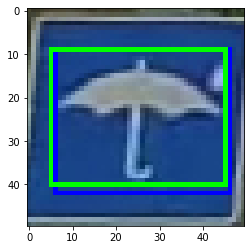

In [159]:
plt.imshow(test_images_arr[20])

In [160]:
def IOU(gt_bb, pred_bb, num, width, height):
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = (gt_bb[num][0] * width), (gt_bb[num][1] * height), (gt_bb[num][2] * width), (gt_bb[num][3] * height)
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = (pred_bb[1][num][0] * width), (pred_bb[1][num][1] * height), (pred_bb[1][num][2] * width), (pred_bb[1][num][3] * height)
    x_inter1 = max(gt_xmin, pred_xmin)
    y_inter1 = max(gt_ymin, pred_ymin)
    x_inter2 = min(gt_xmax, pred_xmax)
    y_inter2 = min(gt_ymax, pred_ymax)
    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(gt_xmax - gt_xmin)
    height_box1 = abs(gt_ymax - gt_ymin)
    width_box2 = abs(pred_xmax - pred_xmin)
    height_box2 = abs(pred_ymax - pred_ymin)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou = area_inter / area_union
    return iou

In [161]:
def bb_box(img, num, color, thickness, width, height):
    start_pt = (int(loc_pred[1][num][0] * width), int(loc_pred[1][num][1] * height))
    end_pt = (int(loc_pred[1][num][2] * width), int(loc_pred[1][num][3] * height))

    st_pt = (int(test_targets_arr[num][0] * width), int(test_targets_arr[num][1] * height))
    e_pt = (int(test_targets_arr[num][2] * width), int(test_targets_arr[num][3] * height))

    img_gt = cv2.rectangle(img[num], st_pt, e_pt, (0, 0, 255), thickness)
    img_bb = cv2.rectangle(img[num], start_pt, end_pt, color, thickness)

    iou_img = round((IOU(test_targets_arr, loc_pred, num, img_ht, img_wd)), 2)
    classes_xtest = np.argmax(loc_pred[0], axis=1)
    plt.xlabel(f'Actual={int(test_labels_arr[num])} || Pred={classes_xtest[num]} || IOU={iou_img}', color= 'g')
    plt.imshow(img_bb)
    plt.savefig(f'./imgs/classlocalize/{num}_{num}.png', dpi=400)
    return plt.show()

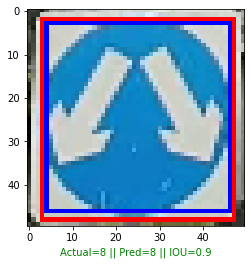

In [162]:
bb_box(test_images_arr, 45, (100, 0, 0), 1, img_ht, img_wd)

In [163]:
img_shuffle = random.sample(range(0, len(test_images_arr)), len(test_images_arr))

In [164]:
gt_area = []
pred_area = []
iou_list = []

In [165]:
pred_area_df = pd.DataFrame(list(loc_pred[1]), columns=['pred_xmin', 'pred_ymin', 'pred_xmax', 'pred_ymax'])

Previously defined height = 50, width = 50

In [166]:
pred_area_df['pred_xmin'] = pred_area_df['pred_xmin'] * width
pred_area_df['pred_ymin'] = pred_area_df['pred_ymin'] * height
pred_area_df['pred_xmax'] = pred_area_df['pred_xmax'] * width
pred_area_df['pred_ymax'] = pred_area_df['pred_ymax'] * height

pred_area_df['area'] = abs((pred_area_df['pred_xmax'] - pred_area_df['pred_xmin']) * (pred_area_df['pred_ymax'] - pred_area_df['pred_ymin']))

In [167]:
for ar in img_shuffle:
    gt_area.append(test_area[ar])
    pred_area.append(pred_area_df['area'].iloc[ar])
    iou_list.append(round((IOU(test_targets_arr, loc_pred, ar, img_ht, img_wd)), 2))

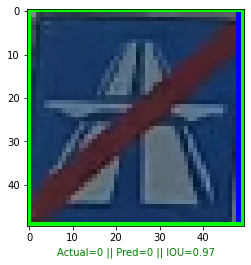

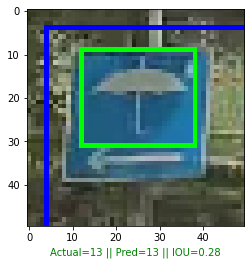

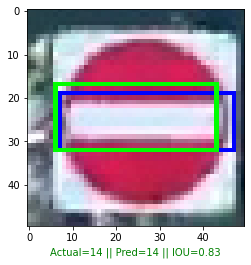

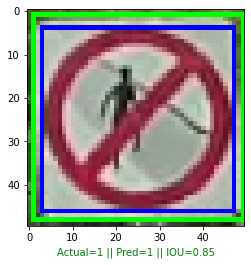

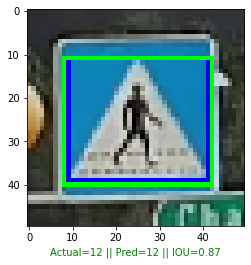

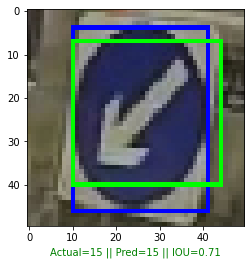

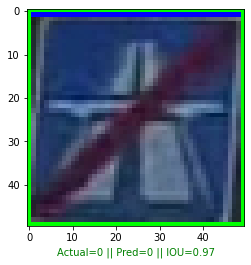

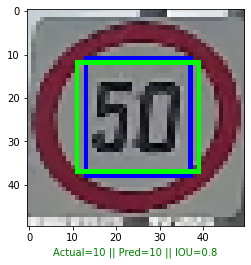

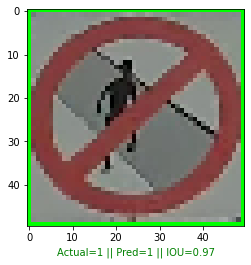

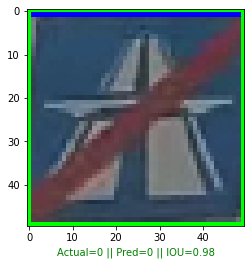

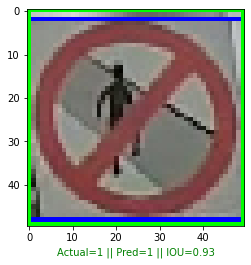

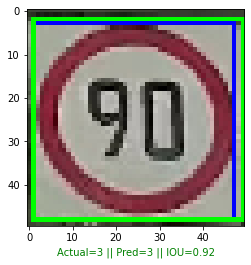

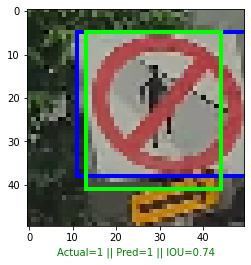

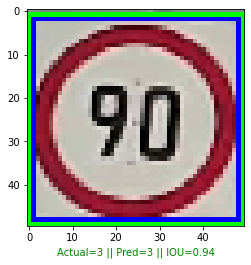

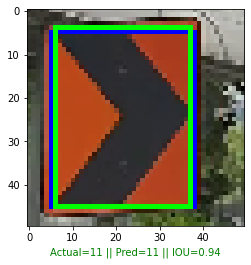

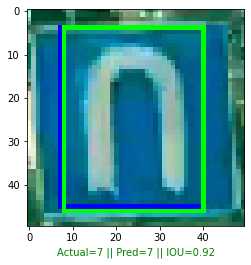

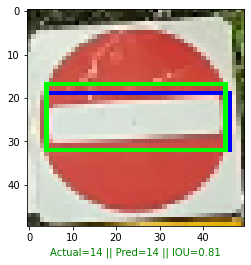

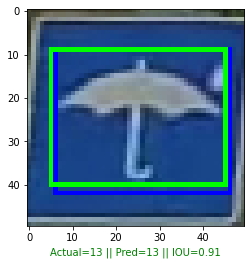

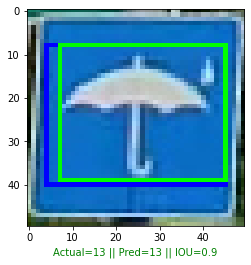

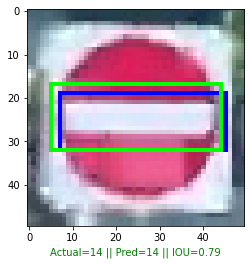

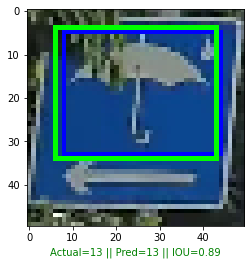

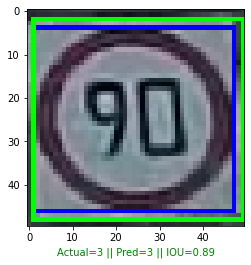

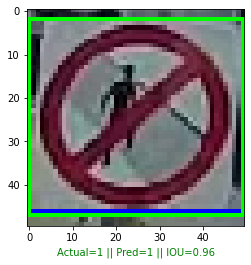

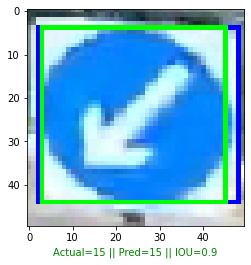

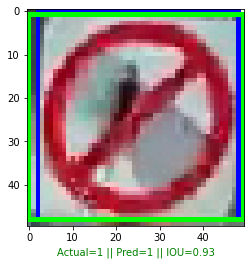

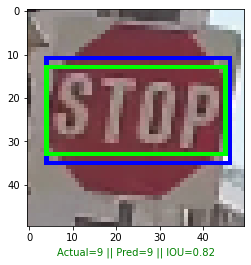

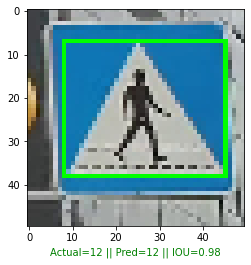

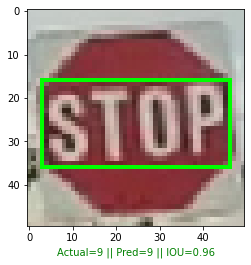

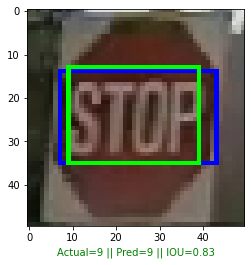

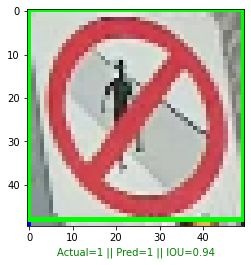

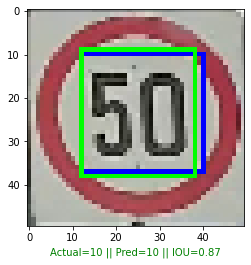

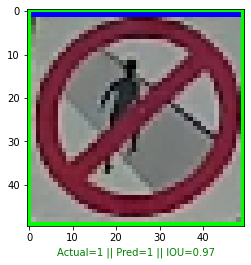

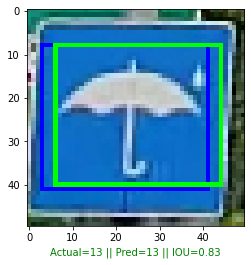

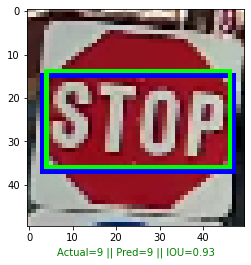

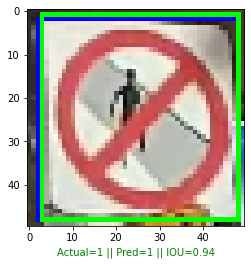

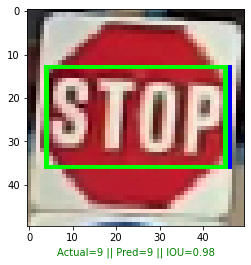

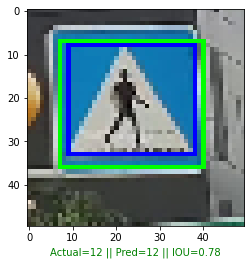

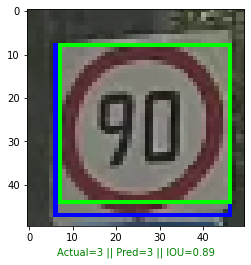

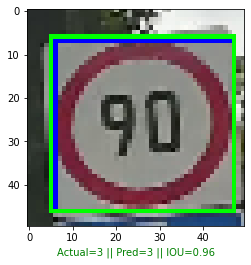

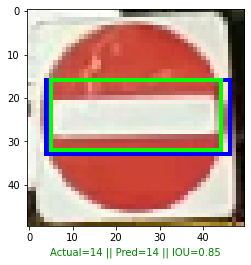

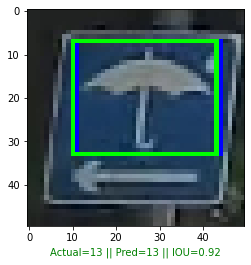

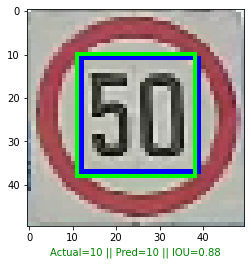

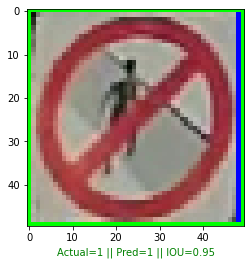

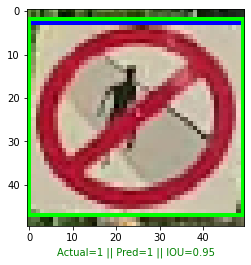

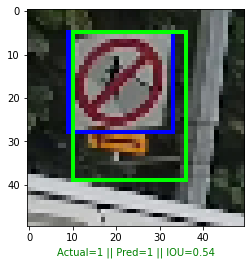

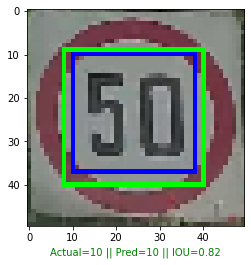

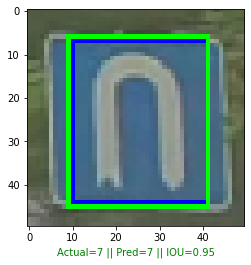

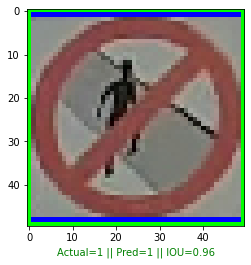

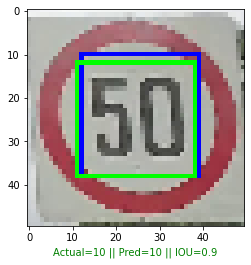

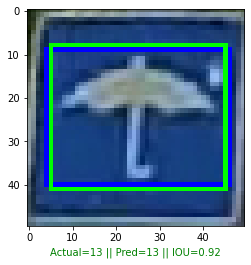

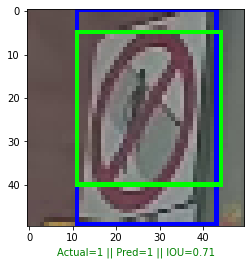

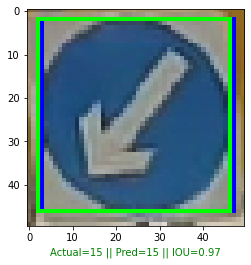

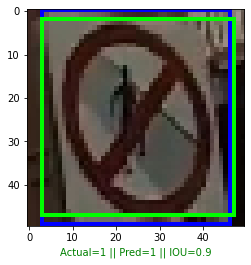

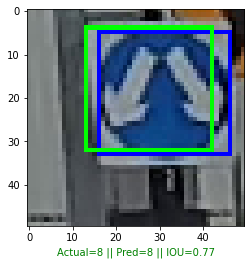

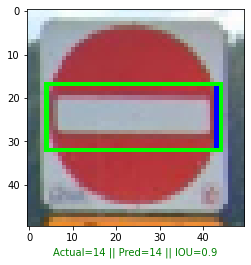

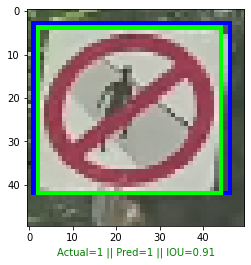

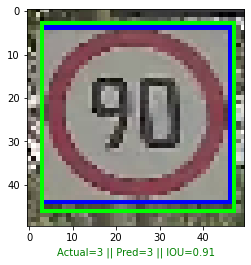

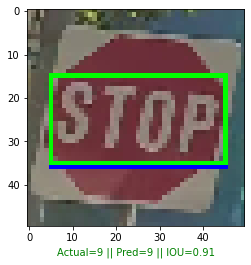

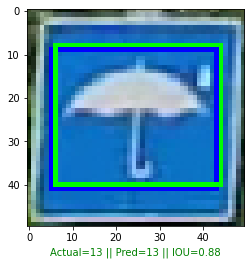

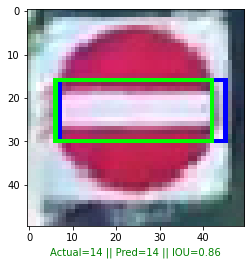

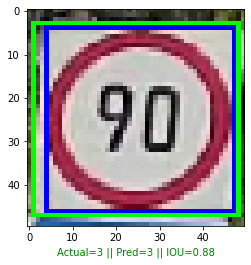

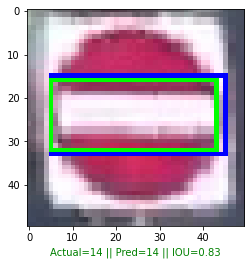

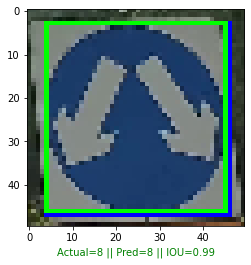

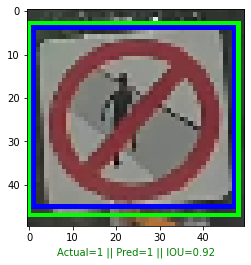

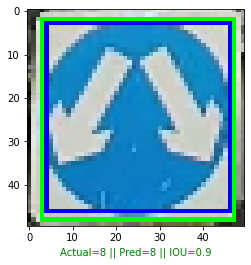

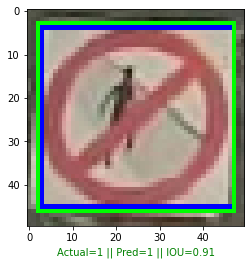

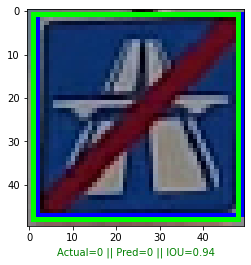

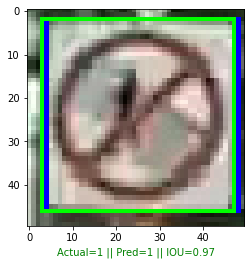

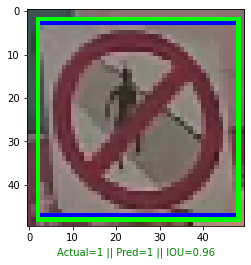

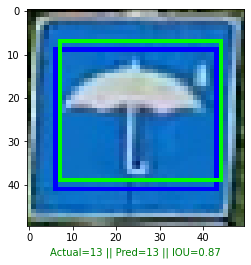

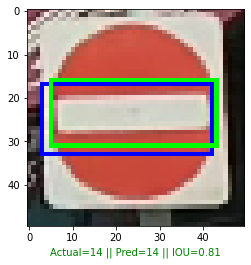

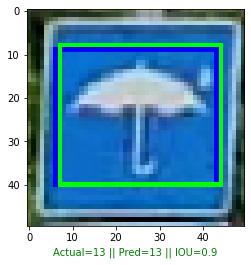

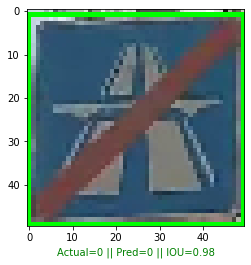

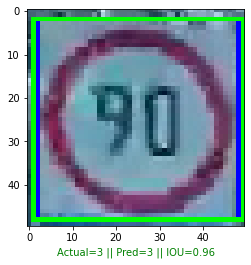

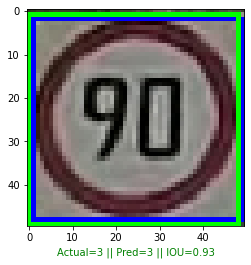

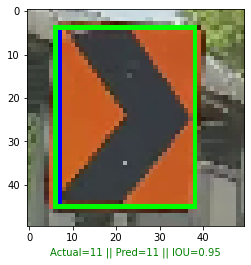

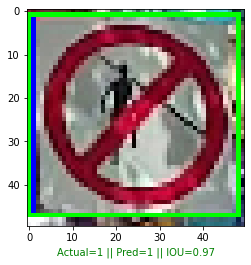

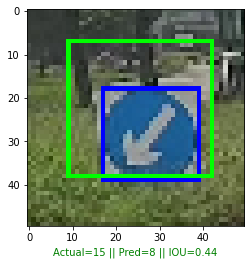

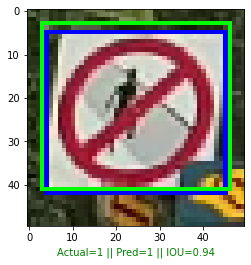

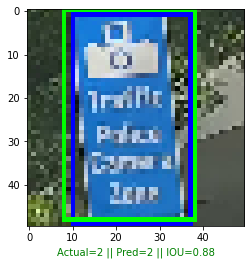

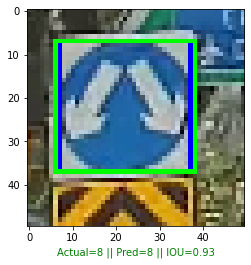

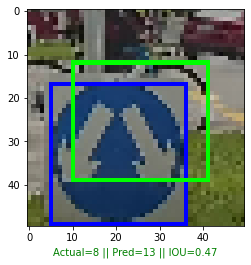

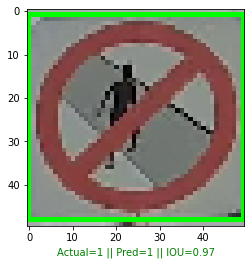

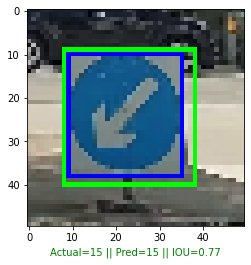

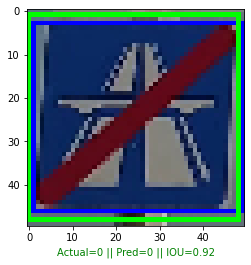

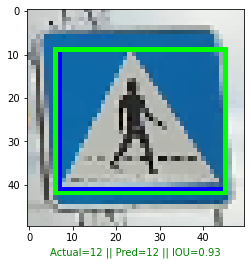

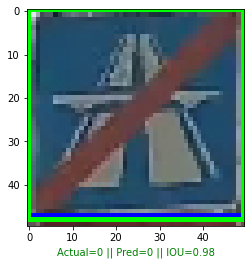

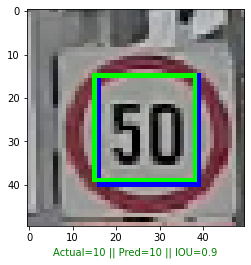

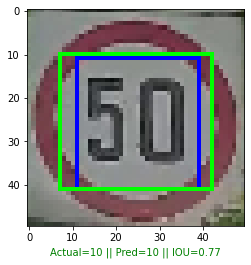

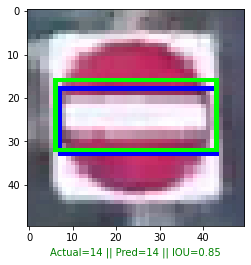

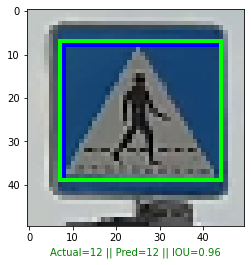

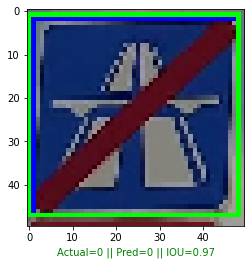

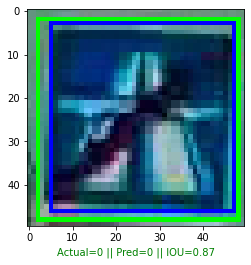

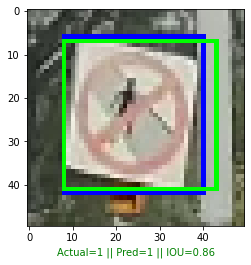

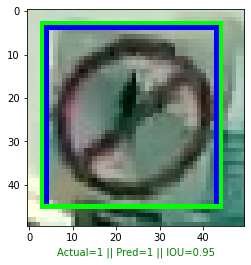

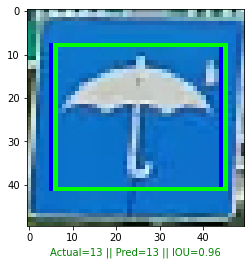

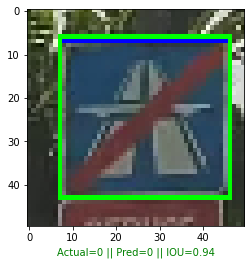

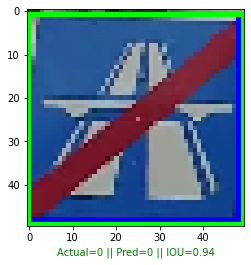

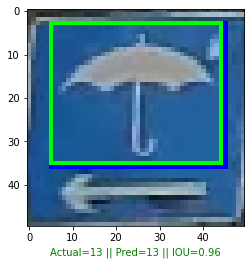

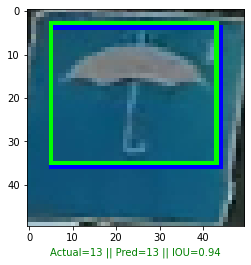

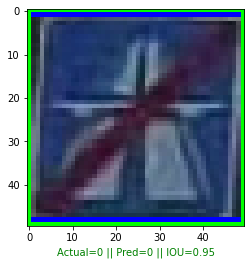

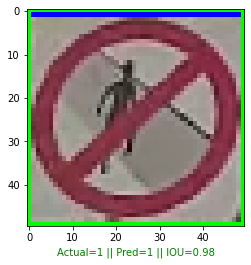

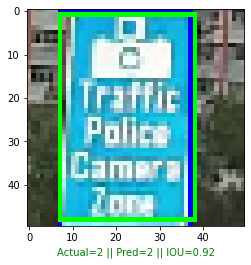

In [168]:
for i in img_shuffle:
    bb_box(test_images_arr, i, (0, 255, 0), 1, img_ht, img_wd)

# IoU as metric for predicted bounding boxes.

In [169]:
iou_score = round((sum(iou_list) / len(iou_list)), 2)

In [170]:
print(f'The IoU accuracy of {len(iou_list)} predicted bounding boxes is {iou_score}.')

The IoU accuracy of 103 predicted bounding boxes is 0.89.


In [171]:
locator_model.save('./saved_models/final/sgtrafficloc/sg_traffic_loc.h5')

In [172]:
locator_model.save_weights('./saved_models/final/sgtrafficloc/weights')

Convert to TFLite for deployment to Raspberry Pi

In [173]:
converter = tf.lite.TFLiteConverter.from_keras_model(locator_model)
tfl_locator = converter.convert()

with open('locator.tflite', 'wb') as f:
    f.write(tfl_locator)

INFO:tensorflow:Assets written to: C:\Users\thien\AppData\Local\Temp\tmp0lk4rq56\assets


INFO:tensorflow:Assets written to: C:\Users\thien\AppData\Local\Temp\tmp0lk4rq56\assets


In [154]:
## End of part 3 - object localization